In [1]:
import numpy as np
import neuroboros as nb
import hyperalignment as ha
import matplotlib.pyplot as plt
from scipy.stats import zscore
from scipy import sparse
from glob import glob
import os
from nilearn import image, masking
from nilearn.image.resampling import coord_transform
from nilearn.maskers.nifti_spheres_masker import _apply_mask_and_get_affinity
from nilearn._utils.niimg_conversions import check_niimg_3d
import time
from sklearn.model_selection import KFold
import pickle
from sys import getsizeof
import seaborn as sns
import pandas as pd
from hyperalignment.procrustes import procrustes
import functools
from hyperalignment.local_template import compute_template
from hyperalignment.ridge import ridge
import time
from statannotations.Annotator import Annotator
from skimage.util import view_as_windows
import sys
from nilearn import datasets

sys.path.append('../../bmigpipe/')
from bmig_graph_analysis.functions.plot_functions import plot_connectivity_sns, plot_connectivity

It is highly recommended to configure Git before using DataLad. Set both 'user.name' and 'user.email' configuration variables.


In [2]:
import nilearn as nl
import numpy as np
import nibabel as nib
import hcp_utils as hcp
from nilearn import surface, plotting
from sklearn import neighbors

pixdim[1,2,3] should be non-zero; setting 0 dims to 1


In [3]:
def create_aal_mask(aal_roi_name, hemis, output_dir='/home/nikvog/od/transformed_ROIs/olfactory/'):
    aal_atlas = datasets.fetch_atlas_aal()
    aal_roi_name_hemis = aal_roi_name + '_' + hemis
    atlas_idx = aal_atlas.indices[aal_atlas.labels.index(aal_roi_name_hemis)]
    aal_img = image.load_img(aal_atlas['maps'])
    aal_arr = aal_img.get_fdata()
    aal_roi = aal_arr == int(atlas_idx)
    aal_roi = image.new_img_like(aal_img, aal_roi)

    # Resample mask.
    example_od_img = image.load_img('/home/nikvog/od/maps/sub-01_run-05_odorant-01.nii.gz')
    aal_roi = image.resample_img(aal_roi, example_od_img.affine, interpolation='nearest',
                                 target_shape=example_od_img.shape)

    aal_mask_filename = '{}/OLFDTI_{}_{}_space-MNI152NLin2009cAsym_res-2.nii.gz'.format(output_dir, hemis, aal_roi_name)
    print('Save as:', aal_mask_filename)
    nib.save(aal_roi, aal_mask_filename)

    return aal_roi

In [4]:
aal_roi_names = ['Precentral', 'Supp_Motor_Area', 'Heschl', 'Frontal_Inf_Tri']
for aal_roi_name in aal_roi_names:
    for hemis in ['L', 'R']:
        aal_roi = create_aal_mask(aal_roi_name, hemis=hemis)

Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_L_Precentral_space-MNI152NLin2009cAsym_res-2.nii.gz
Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_R_Precentral_space-MNI152NLin2009cAsym_res-2.nii.gz
Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_L_Supp_Motor_Area_space-MNI152NLin2009cAsym_res-2.nii.gz
Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_R_Supp_Motor_Area_space-MNI152NLin2009cAsym_res-2.nii.gz
Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_L_Heschl_space-MNI152NLin2009cAsym_res-2.nii.gz
Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_R_Heschl_space-MNI152NLin2009cAsym_res-2.nii.gz
Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_L_Frontal_Inf_Tri_space-MNI152NLin2009cAsym_res-2.nii.gz
Save as: /home/nikvog/od/transformed_ROIs/olfactory//OLFDTI_R_Frontal_Inf_Tri_space-MNI152NLin2009cAsym_res-2.nii.gz


In [3]:
html_view = plotting.view_img(aal_roi, threshold=0.8, vmax=None,
                              cut_coords=[-42, -16, 52],
                              title=None, cmap='bwr')
html_view

NameError: name 'aal_roi' is not defined

In [4]:
def load_mask(ROI_filename): 
    roi_mask = image.load_img(ROI_filename)
    
    roi_mask = image.new_img_like(roi_mask, roi_mask.get_fdata() > 0)
       
    # Compute world coordinates of the seeds
    roi_mask_arr, process_mask_affine = masking.load_mask_img(
        roi_mask
    )

    n_vox = np.count_nonzero(roi_mask.dataobj)
    print('Voxels inside mask:', n_vox)
    
    return roi_mask, roi_mask_arr, n_vox

In [7]:
mask_filename = '/home/nikvog/od/transformed_ROIs/olfactory/OLFDTI_mean_MNI_R_olfactory_bulb_space-MNI152NLin2009cAsym_res-2.nii.gz'
mask_filename = '/home/nikvog/od/transformed_ROIs/olfactory/OLFDTI_L_AON_space-MNI152NLin2009cAsym_res-2.nii.gz'
roi_mask, roi_mask_arr, n_vox = load_mask(mask_filename)

Voxels inside mask: 383


/home/simwei/anaconda3/envs/hyper/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/home/simwei/anaconda3/envs/hyper/lib/python3.12/site-packages/nilearn/image/resampling.py:293: UserWarning: Resampling binary images with continuous or linear interpolation. This might lead to unexpected results. You might consider using nearest interpolation instead.
  warnings.warn(



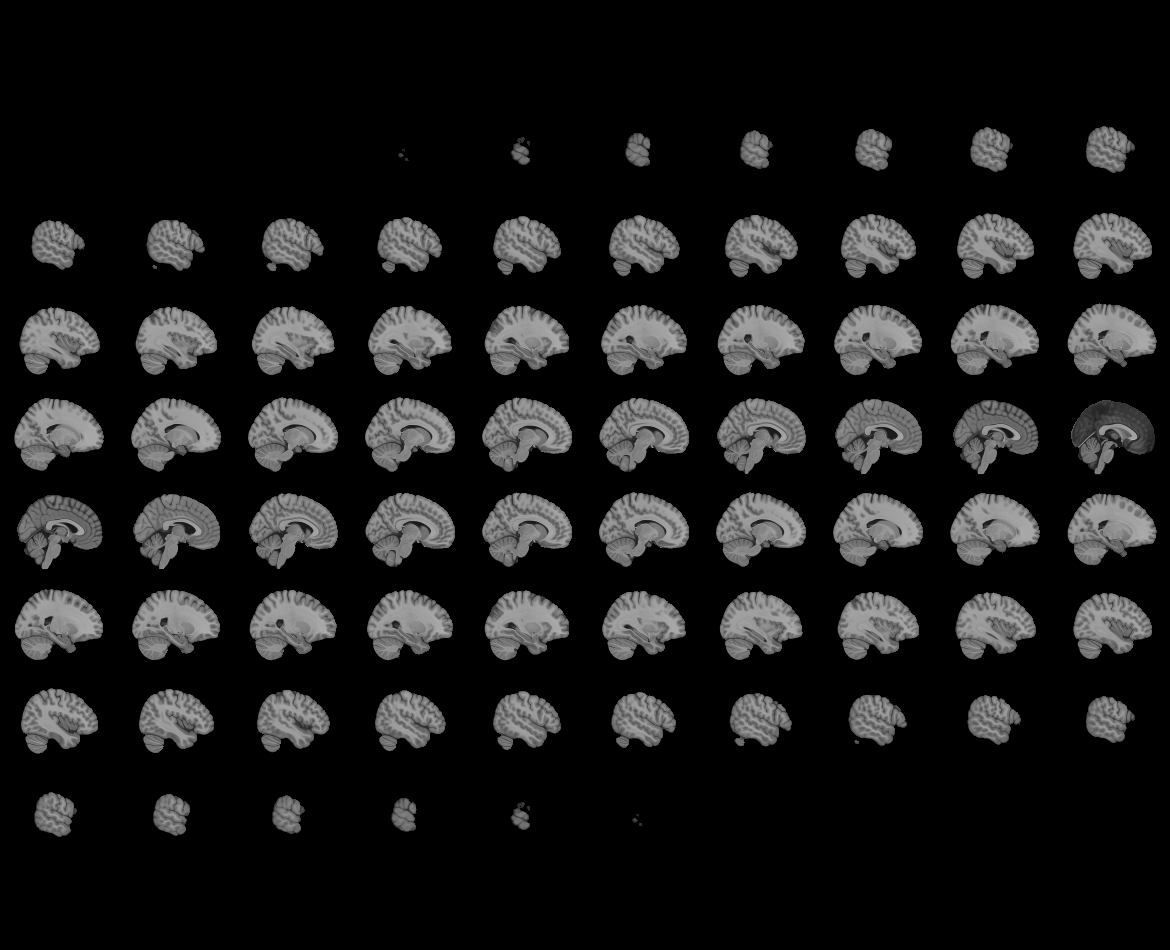
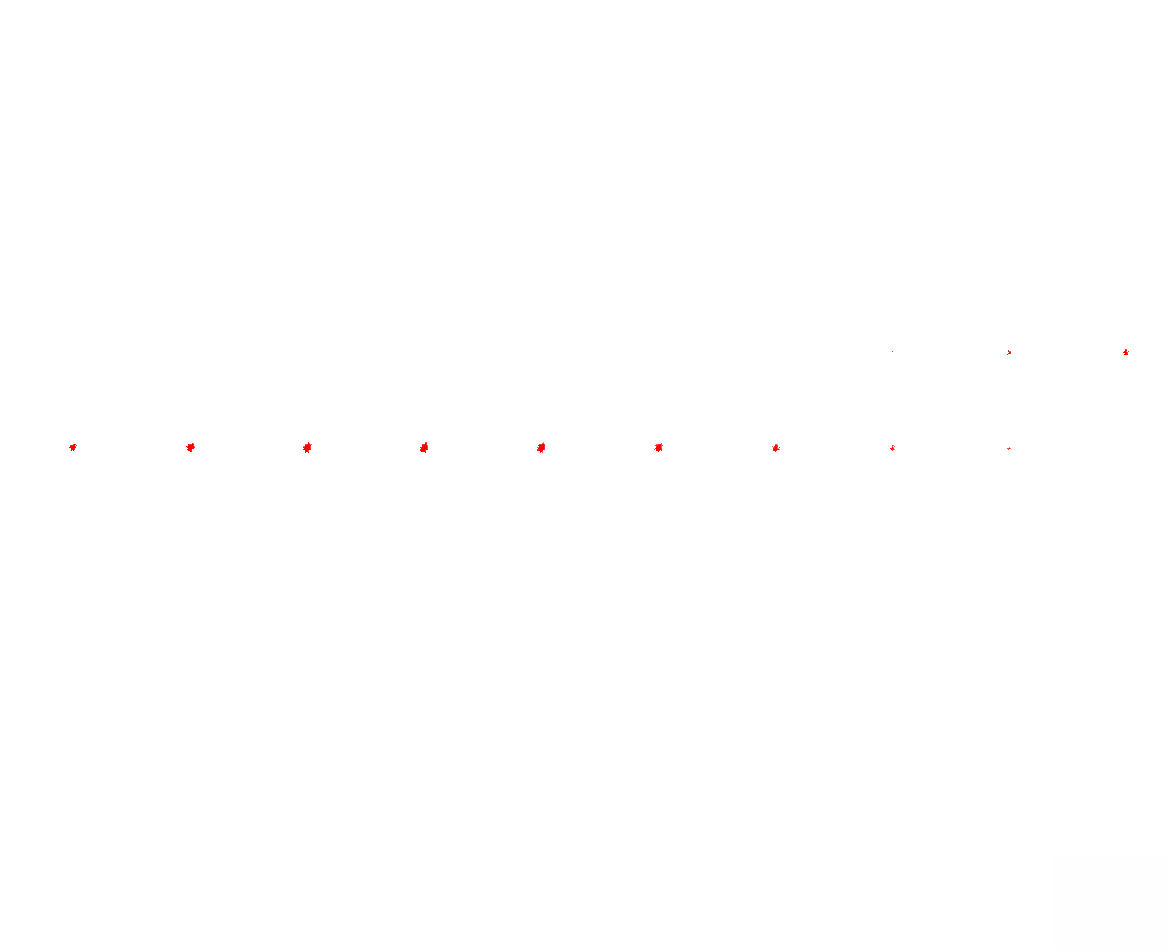

In [8]:
html_view = plotting.view_img(roi_mask, threshold=0.8, vmax=None,
                              cut_coords=[-42, -16, 52],
                              title=None, cmap='bwr')
html_view

In [9]:
def load_and_mask(subs, ods, runs, od_dir, roi_mask, verbose=False):
    sub_maps = []
    for sub in subs:
        ods_maps = []
        for od in ods:
            for run in runs:
                pattern = 'sub-{:02d}_run-{:02d}_odorant-{:02d}.nii.gz'.format(sub, run, od)
                filename = os.path.join(od_dir, pattern)
                if verbose:
                    print('Load:', filename)
                od_map = image.load_img(filename)
    
                # Get data insede mask.
                X = masking.apply_mask_fmri(od_map, roi_mask)
                ods_maps.append(X)
        ods_maps = np.stack(ods_maps)
        sub_maps.append(ods_maps)
    sub_maps = np.stack(sub_maps)
    
    return sub_maps

In [10]:
def load_od_maps(subs, ods, runs, od_dir, verbose=False):
    sub_maps = []
    for sub in subs:
        ods_maps = []
        for od in ods:
            for run in runs:
                pattern = 'sub-{:02d}_run-{:02d}_odorant-{:02d}.nii.gz'.format(sub, run, od)
                filename = os.path.join(od_dir, pattern)
                if verbose:
                    print('Load:', filename)
                od_map = image.load_img(filename)
                ods_maps.append(od_map)
        sub_maps.append(ods_maps)    
    return sub_maps

### Check inter vs intra subject similarity.

In [11]:
def sanity_check(sub_maps):
    n_subs = sub_maps.shape[0]
    corr_within, corr_betw = [], []
    for sub_i in range(n_subs):
        for sub_j in range(sub_i, n_subs):
            sub_corr = np.corrcoef(sub_maps[sub_i], sub_maps[sub_j])
            n_corr_maps = sub_corr.shape[0] // 2
            sub_corr = sub_corr[:n_corr_maps, n_corr_maps:]
            
            sub_corr_unique = sub_corr[np.tril_indices(sub_corr.shape[0], k=-1)]
            
            mean_corr = np.mean(sub_corr_unique)
            
            if sub_i == sub_j:
                corr_within.append(mean_corr)
            else:
                corr_betw.append(mean_corr)

    return corr_within, corr_betw


def remove_diag(A):
    B = A[~np.eye(A.shape[0],dtype=bool)].reshape(A.shape[0],-1)
    return B


def cut_matrix(A, n_cuts):
    A_cut = np.zeros((n_cuts, n_cuts, A.shape[0]//n_cuts, A.shape[1]//n_cuts))
    for i in range(n_cuts):
        for j in range(n_cuts):
            i_start = 10 * i
            i_end = 10 * (i + 1)
            j_start = 10 * j
            j_end = 10 * (j + 1)
            A_cut[i, j] = A[i_start:i_end, j_start:j_end]
            
    return A_cut

In [12]:
def sanity_check_od(sub_maps, ods):
    n_ods = len(ods)
    n_subs = sub_maps.shape[0]
    corr_within, corr_betw = [], []
    corr_od_within, corr_od_betw = [], []
    for sub_i in range(n_subs):
        for sub_j in range(sub_i, n_subs):
            sub_corr = np.corrcoef(sub_maps[sub_i], sub_maps[sub_j])     
            n_corr_maps = sub_corr.shape[0] // 2
            sub_corr = sub_corr[:n_corr_maps, n_corr_maps:]
            sub_corr = (sub_corr + sub_corr.T) / 2
            
            # Compute mean similarity of all beta maps and odors.
            sub_corr_unique = sub_corr[np.tril_indices(sub_corr.shape[0], k=-1)]
            mean_corr = np.mean(sub_corr_unique)
            
            if sub_i == sub_j:
                corr_within.append(mean_corr)
            else:
                corr_betw.append(mean_corr)
    
            # Compute mean similarity of all beta maps of one odor.
            sub_corr_ods = cut_matrix(sub_corr, n_ods)
            corr_ods = np.zeros((n_ods, n_ods))
            for od_i in range(n_ods):
                for od_j in range(n_ods):
                    if sub_i != sub_j:
                        corr_od = np.mean(sub_corr_ods[od_i, od_j])
                    else:
                        corr_od = np.mean(remove_diag(sub_corr_ods[od_i, od_j]))
                    corr_ods[od_i, od_j] = corr_od
    
            if sub_i == sub_j:
                corr_od_within.append(corr_ods)
            else:
                corr_od_betw.append(corr_ods)

    return corr_within, corr_betw, corr_od_within, corr_od_betw

### Perform hyperalignment.

In [13]:
def perform_cv_hyper(sub_maps, 
                     cv=KFold(n_splits=10),
                     sl_func=functools.partial(ridge, alpha=1e3)):

    fold_maps_train_hat, fold_maps_test_hat = [], []
    fold_maps_train, fold_maps_test = [], []
    
    for n_fold, (train_idx, test_idx) in enumerate(cv.split(sub_maps[0])):  # CV 1: test odor 1...
        # Create training data.
        sub_maps_train, sub_maps_test = [], []
        for sub_map in sub_maps:  
            sub_maps_train.append(sub_map[train_idx])    
            sub_maps_test.append(sub_map[test_idx])    
        sub_maps_train = np.stack(sub_maps_train)
        sub_maps_test = np.stack(sub_maps_test)
        
        wt = compute_template(sub_maps_train, kind='pca', common_topography=True)
    
        W_subs, sub_maps_train_hat, sub_maps_test_hat = [], [], []
        for sub_map_train, sub_map_test in zip(sub_maps_train, sub_maps_test):
            # W_subs.append(sl_func(sub_map, wt))
            W_sub = sl_func(sub_map_train, wt)
            sub_maps_train_hat.append(sub_map_train @ W_sub)        
            sub_maps_test_hat.append(sub_map_test @ W_sub)
    
        fold_maps_train_hat.append(sub_maps_train_hat)
        fold_maps_test_hat.append(sub_maps_test_hat)
        fold_maps_train.append(sub_maps_train)
        fold_maps_test.append(sub_maps_test)

    return fold_maps_train_hat, fold_maps_test_hat, fold_maps_train, fold_maps_test

In [14]:
def compute_odor_similarities(fold_maps):
    n_subs = len(fold_maps[0])
    fold_corrs = []
    for fold_map in fold_maps:
        corr_within, corr_betw = [], []
        for sub_i in range(n_subs):
            for sub_j in range(sub_i, n_subs):
                # print(sub_i, sub_j)
                sub_corr = np.corrcoef(fold_map[sub_i], fold_map[sub_j])  # Get only unqiue pairs!
                n_corr_maps = sub_corr.shape[0] // 2
                sub_corr = sub_corr[:n_corr_maps, n_corr_maps:]

                if sub_i != sub_j:
                    mean_corr = np.mean(sub_corr)
                else:
                    mean_corr = np.mean(remove_diag(sub_corr))
                
                if sub_i == sub_j:
                    corr_within.append(mean_corr)
                else:
                    corr_betw.append(mean_corr)
    
        subcomb_mean = np.mean(corr_betw)
    
        fold_corrs.append(corr_betw)

    return fold_corrs

In [ ]:
ROI_dir = '/home/nikvog/od/transformed_ROIs/olfactory/'

subs = list(range(1, 32))
subs.remove(9)
ods = range(1, 11)
runs = range(1, 11)
od_dir = '/home/nikvog/od/maps/'
sl_func = functools.partial(ridge, alpha=1e3)
# sl_func = functools.partial(procrustes, reflection=True, scaling=False)

ROI_filenames = glob(ROI_dir + '*.nii*')
ROI_filenames.sort()
ROI_isc = {}
for ROI_filename in ROI_filenames:
    print('Process:', ROI_filename)
    roi_name = ROI_filename[:-39].split('DTI_')[1]
    ROI_isc[roi_name] = {}
    
    # Create ROI mask.
    roi_mask, roi_mask_arr, n_vox = load_mask(ROI_filename)
    ROI_isc[roi_name]['n_vox'] = n_vox

    start_time_bm = time.time()
    # Load and mask beta maps.
    sub_maps = load_and_mask(
        subs=subs, 
        ods=ods, 
        runs=runs, 
        od_dir=od_dir, 
        roi_mask=roi_mask, 
        verbose=False)
    end_time_am = time.time()
    print("Time (mins) needed for loading and masking: " + str((end_time_am - start_time_bm)/60))
    
    # Compare whitin subject correlations with between subject correlations.
    corr_within, corr_betw, corr_od_within, corr_od_betw = sanity_check_od(sub_maps, ods)
    print('Within corr: {:.3f}, Between corr: {:.3f}'.format(np.mean(corr_within), np.mean(corr_betw)))
    
    ROI_isc[roi_name]['corr_within'] = corr_within
    ROI_isc[roi_name]['corr_betw'] = corr_betw
    ROI_isc[roi_name]['corr_od_within'] = corr_od_within
    ROI_isc[roi_name]['corr_od_betw'] = corr_od_betw


    # Perform hyperalignment.
    fold_maps_train_hat, fold_maps_test_hat, fold_maps_train, fold_maps_test = perform_cv_hyper(
        sub_maps, 
        sl_func=sl_func)

    # Check similarity of all beta maps between subjects.
    ROI_isc[roi_name]['train_hat'] = compute_odor_similarities(fold_maps_train_hat)
    ROI_isc[roi_name]['test_hat'] = compute_odor_similarities(fold_maps_test_hat)
    ROI_isc[roi_name]['train'] = compute_odor_similarities(fold_maps_train)
    ROI_isc[roi_name]['test'] = compute_odor_similarities(fold_maps_test)
    
    

Process: /home/nikvog/od/transformed_ROIs/olfactory/OLFDTI_L_AON_space-MNI152NLin2009cAsym_res-2.nii.gz
Voxels inside mask: 383
Time (mins) needed for loading and masking: 5.820492398738861
Within corr: 0.044, Between corr: 0.012
Process: /home/nikvog/od/transformed_ROIs/olfactory/OLFDTI_L_Frontal_Inf_Tri_space-MNI152NLin2009cAsym_res-2.nii.gz
Voxels inside mask: 2529


In [ ]:
# Save output array.
filename_isc = r'./results_ROIs/ROIs_isc_nsubs-{}_nfolds-{}.pkl'.format(len(subs), 10)
with open(filename_isc, "wb") as output_file:
    pickle.dump(ROI_isc, output_file)

In [42]:
filename_isc = r'./results_ROIs/ROIs_isc_nsubs-{}_nfolds-{}.pkl'.format(len(subs), 10)
with open(filename_isc, "rb") as input_file:
    ROI_isc_test = pickle.load(input_file)

In [17]:
def make_od_df(ROI_isc, roi_name, dataset, labels):
    od_df = pd.DataFrame(ROI_isc[roi_name][dataset]).transpose().add_prefix('odor_sim')
    od_df['dataset'] = dataset
    od_df['ROI'] = roi_name
    od_df.index.name = 'sub_pair'
    od_df = od_df.reset_index()
    od_df = pd.wide_to_long(od_df, stubnames='odor_sim', i='sub_pair', j='n_odor')
    od_df = od_df.reset_index()

    for n_od, label in enumerate(labels):
        od_df.loc[od_df['n_odor'] == n_od, 'odor'] = label
    
    return od_df

In [18]:
labels = ['grass', 'leather', 'lilac', 'onion', 'smoked', 'rose', 'pear',
'caramel', 'orange', 'turpentine']

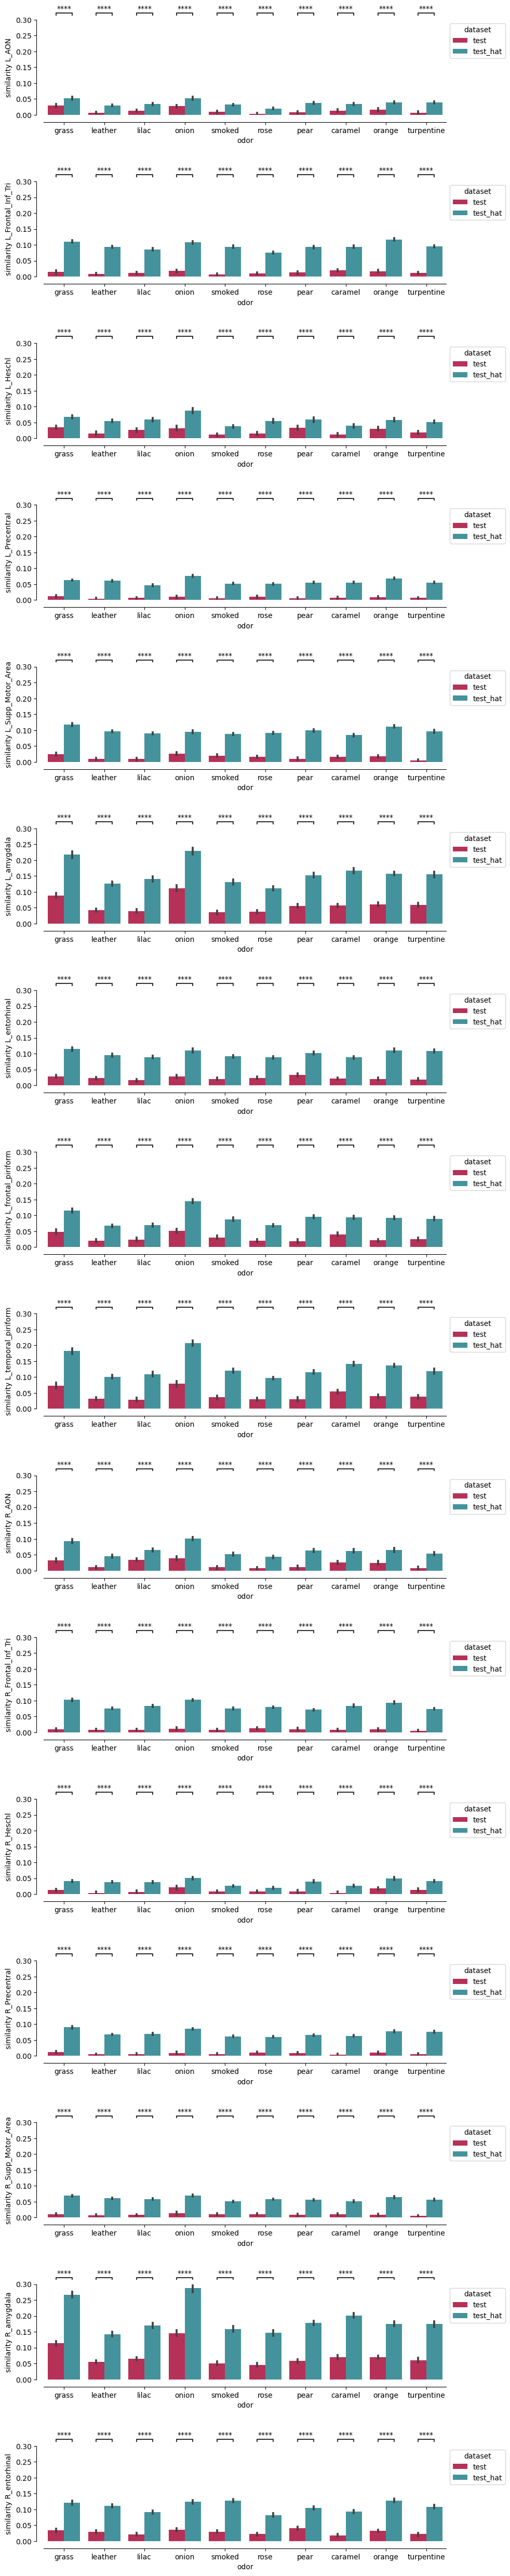

In [19]:
roi_names = list(ROI_isc.keys())
roi_names = roi_names[:-2]
save_dir = ''  # './results_ROIs/plots/'
plt_dataset_1 = 'test'
plt_dataset_2 = 'test_hat'

correction = 'fdr_bh'  # None  # 'bonferroni'  #
test = "t-test_paired"  #
ymax = 0.3
fig, axs = plt.subplots(len(roi_names), 1, figsize=(10, len(ROI_isc)*3.5))
fig.subplots_adjust(hspace=0.7)
palette = [sns.color_palette("rocket", 7)[3], sns.color_palette("mako", 7)[4]] # 'Spectral'  # sns.color_palette("rocket", 7)  # sns.color_palette('Spectral')

for n_roi, roi_name in enumerate(roi_names):
    # fig, axs = plt.subplots(1, 1, figsize=(10, 3.5))
    od_df_1 = make_od_df(ROI_isc, roi_name, plt_dataset_1, labels)
    od_df_2 = make_od_df(ROI_isc, roi_name, plt_dataset_2, labels)

    # Plot.
    data_plt = pd.concat([od_df_1, od_df_2])
    hue = 'dataset'
    x = 'odor'
    y = 'odor_sim'
    ax = axs[n_roi]  # axs #
    ax = sns.barplot(data=data_plt, palette=palette, x=x, y=y, hue=hue, ax=ax)
    ax.set(ylabel='similarity ' + roi_name)
    ax.set_ylim([0, ymax])
    sns.despine(offset=10, trim=False)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))

    # Perform statistical testing.
    pairs = [((od, 'test'), (od, 'test_hat')) for od in data_plt['odor'].unique()]
    annotator = Annotator(ax, pairs, data=data_plt, x=x, y=y, hue=hue,
                          verbose=False)
    annotator.configure(test=test, text_format='star', loc='outside',
                        comparisons_correction=correction)
    test_results = annotator.apply_test().annotate(line_offset=0.05)

# Save figure.
if save_dir != '':
    path_savefig = '{}/HA_olfactory_ROIs_all.svg'.format(save_dir, '')
    # path_savefig = '{}/HA_olfactory_ROIs_{}.svg'.format(save_dir, roi_name)
    plt.savefig(path_savefig, bbox_inches='tight', dpi=350, format="svg")
    print('Save figure in: %s' % path_savefig)

In [22]:
def plot_connectivity(Conn, regionnames=None, add_lines=True,  plt_title=None, min_val=None, max_val=None,
                      figsize=(14, 14), add_colorbar=True, ax=None):
    # plt.figure(figsize=figsize)
    # im = ax.imshow(Conn, cmap='jet', vmin=min_val, vmax=max_val)
    im = sns.heatmap(Conn, ax=ax)
    plt.grid(False)

    # Add labels.
    if regionnames is not None:
        # plt.xticks(np.arange(len(regionnames)), regionnames, rotation=90, size=7)
        ax.set_xticks(np.arange(len(regionnames)), regionnames, rotation=90, size=7)
        # plt.yticks(np.arange(len(regionnames)), regionnames, size=7)
        ax.set_yticks(np.arange(len(regionnames)), regionnames, size=7)

    # Add hemisphere lines.
    if add_lines:
        num_regions = Conn.shape[0]
        plt.axvline(num_regions/2 - .5, color='black')
        plt.axhline(num_regions/2 - .5, color='black')
    if plt_title:
        ax.set_title('{}'.format(plt_title))
    if add_colorbar:
        plt.colorbar(im, fraction=0.02, pad=0.03)
    plt.show()

In [23]:
roi_names_l = roi_names[:len(roi_names)//2]
roi_names_r = roi_names[len(roi_names)//2:]

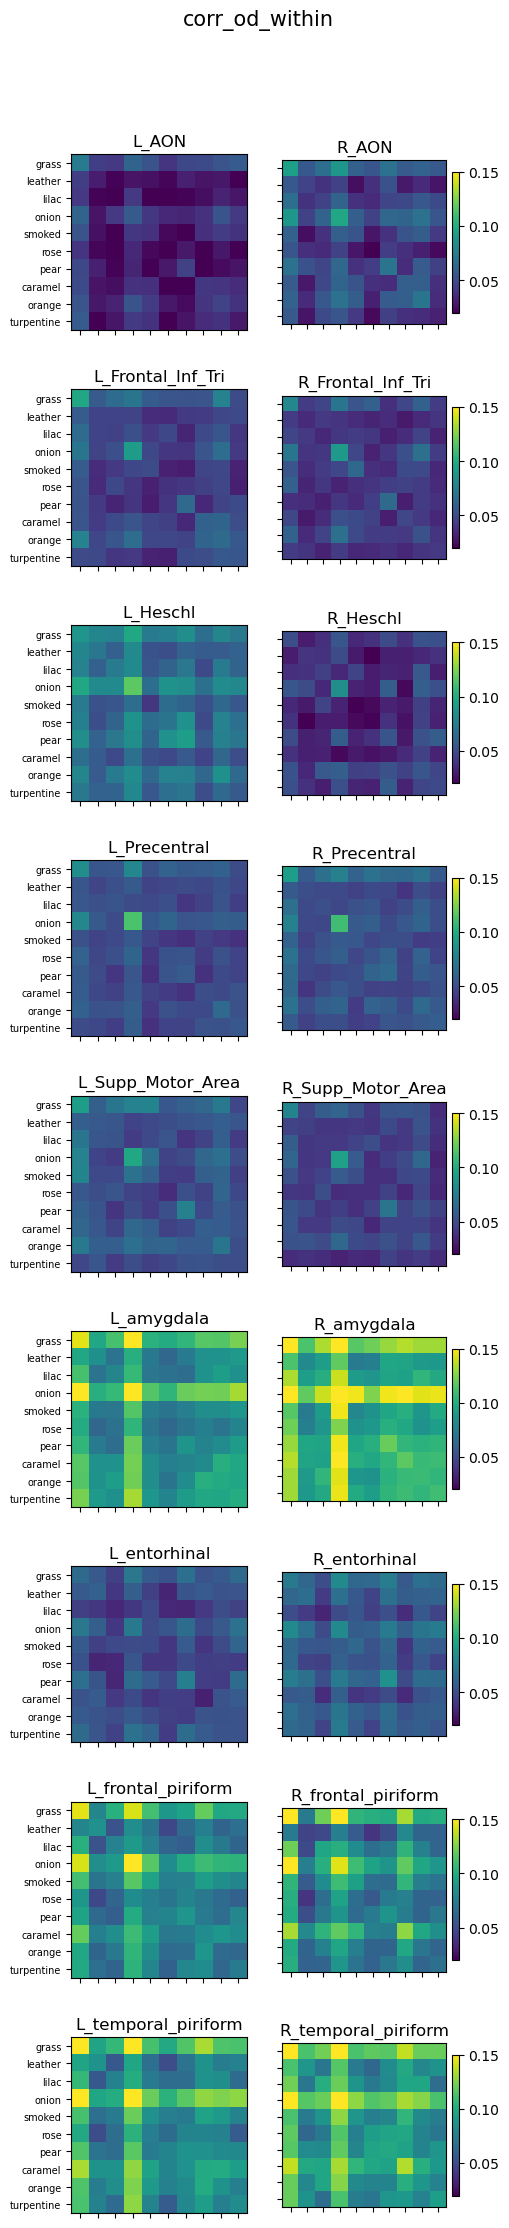

In [27]:
min_val = 0.02
max_val = 0.15

dataset = 'corr_od_within'  # 'corr_od_betw'  #
fig, axs = plt.subplots(len(roi_names)//2, 2, figsize=(5, len(roi_names)*1.5))
plt.suptitle(dataset, y=0.93, size=15)
for n_hemi, roi_names_plt in enumerate([roi_names_l, roi_names_r]):
    for n_roi, roi_name in enumerate(roi_names_plt):
        avg_corr_od_within = np.mean(ROI_isc[roi_name][dataset], axis=0)
        avg_corr_od_betw = np.mean(ROI_isc[roi_name][dataset], axis=0)
        
        ax = axs[n_roi, n_hemi]
        im = ax.imshow(avg_corr_od_within, vmin=min_val, vmax=max_val)
        
        ax.set_xticks(np.arange(len(labels)), [], rotation=90, size=7)
        ax.set_yticks(np.arange(len(labels)), labels, size=7, rotation=0)
        if n_hemi == 1:
            ax.set_yticks(np.arange(len(labels)), [], size=7, rotation=0)
            plt.colorbar(im, fraction=0.04, pad=0.03)        
        plt_title = roi_name
        ax.set_title('{}'.format(plt_title))


/home/simwei/anaconda3/envs/hyper/lib/python3.12/site-packages/numpy/core/fromnumeric.py:771: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)



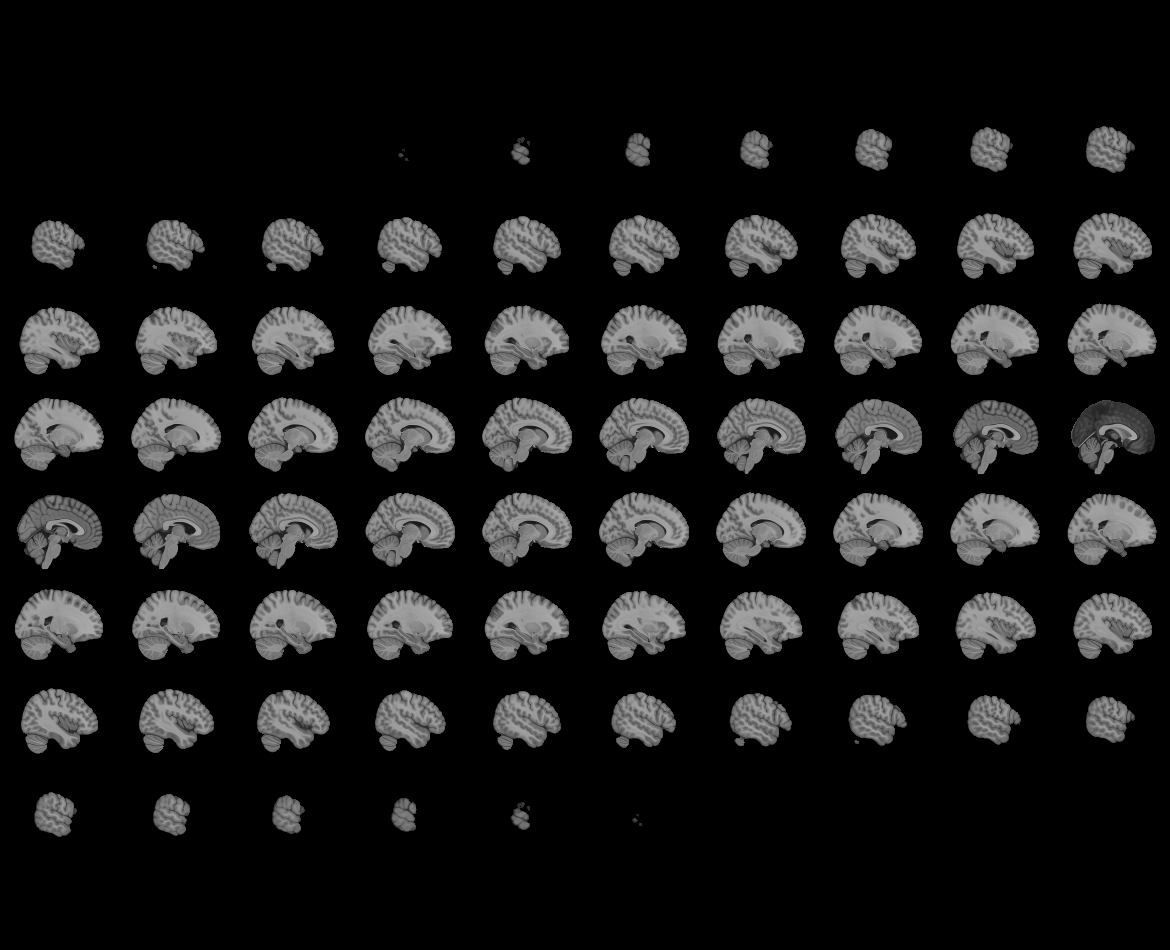
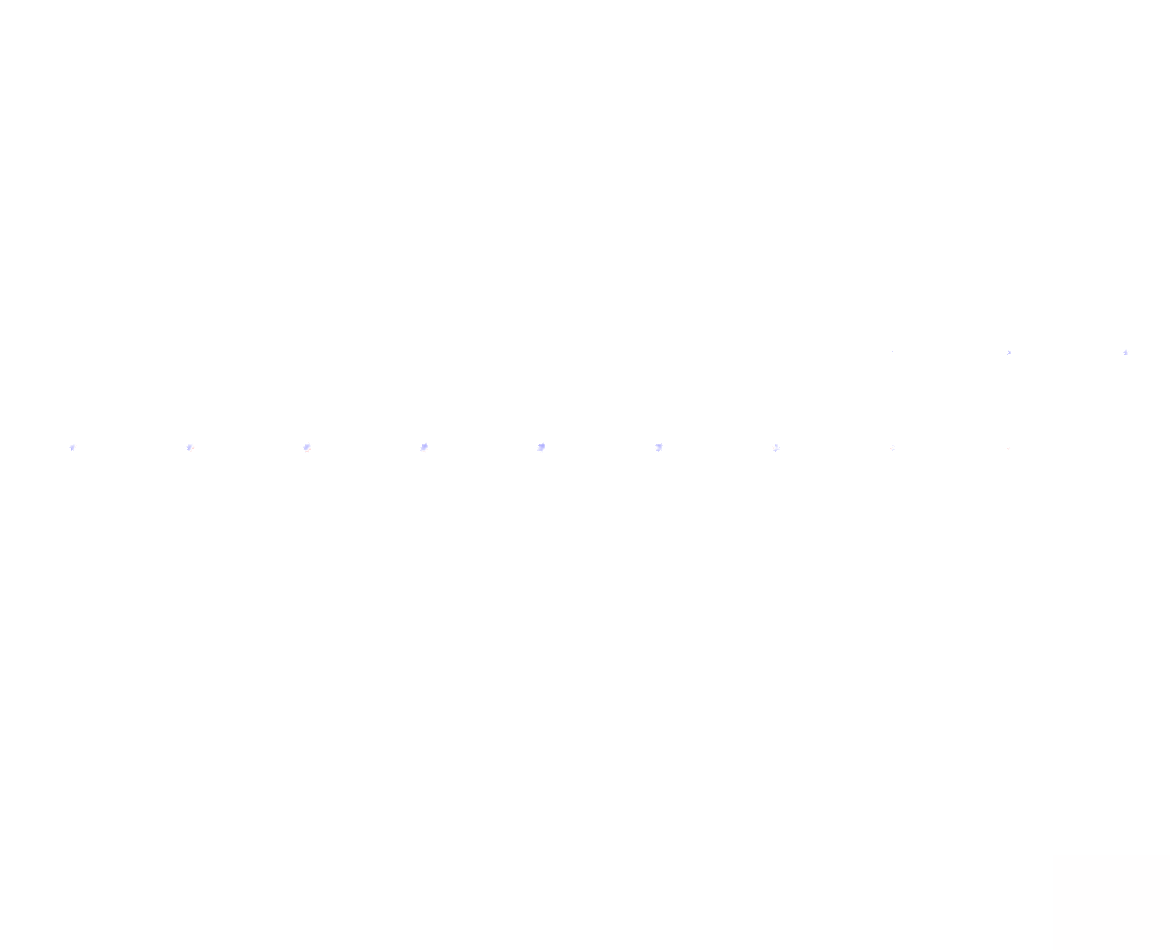

In [34]:
# Correlate transformed training data.
r_train = np.mean(zscore(sub_maps[0], axis=0) * zscore(sub_maps[1], axis=0), axis=0)

r_3D = np.zeros(od_map.shape)
r_3D[roi_mask_arr] = r_train

plt_r = image.new_img_like(od_map, r_3D)

html_view = plotting.view_img(plt_r, threshold=0.0001, vmax=0.8,
                              cut_coords=[-42, -16, 52],
                              title=None, cmap='bwr')
html_view

### Experimental.

In [ ]:
roi_name = 'R_frontal_piriform'

folds_df_1 = pd.DataFrame(ROI_isc[roi_name]['train']).transpose().add_prefix('odor ')

ax = sns.barplot(folds_df_1, palette='Spectral')

ax.set_ylim([0, 0.3])

(0.0, 0.3)

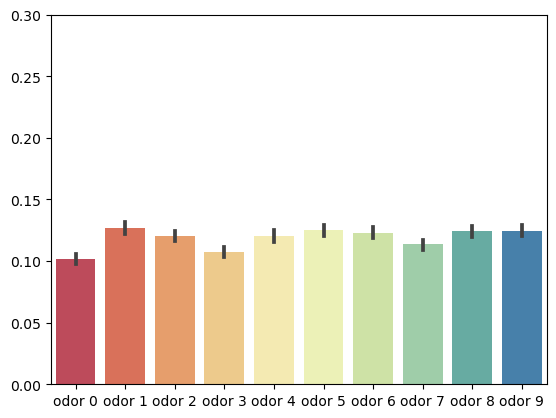

In [135]:
folds_df_2 = pd.DataFrame(ROI_isc[roi_name]['train_hat']).transpose().add_prefix('odor ')

ax = sns.barplot(folds_df_2, palette='Spectral')

ax.set_ylim([0, 0.3])

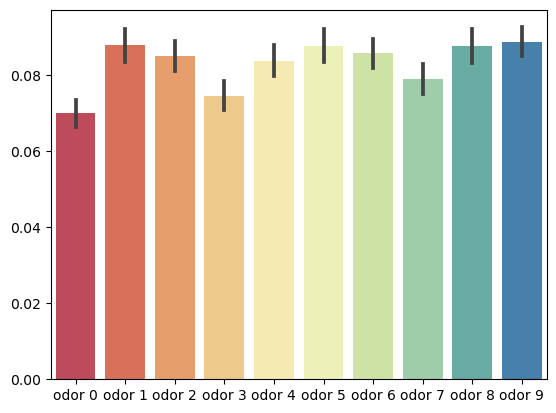

In [136]:
ax = sns.barplot(folds_df_2.sub(folds_df_1), palette='Spectral')

In [187]:
corr_within, corr_betw, corr_od_within, corr_od_betw = sanity_check_od(sub_maps, ods)

In [188]:
avg_corr_od_within = np.mean(corr_od_within, axis=0)
avg_corr_od_betw = np.mean(corr_od_betw, axis=0)

In [189]:
labels = ['grass', 'leather', 'lilac', 'onion', 'smoked', 'rose', 'pear',
'caramel', 'orange', 'turpentine']

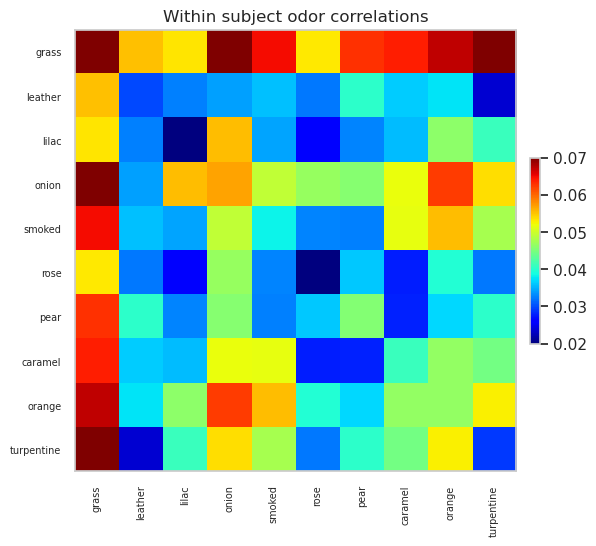

In [190]:
plot_connectivity(avg_corr_od_within, labels, add_lines=False, plt_title='Within subject odor correlations',
                  min_val=0.02, max_val=0.07, figsize=(6, 6))   

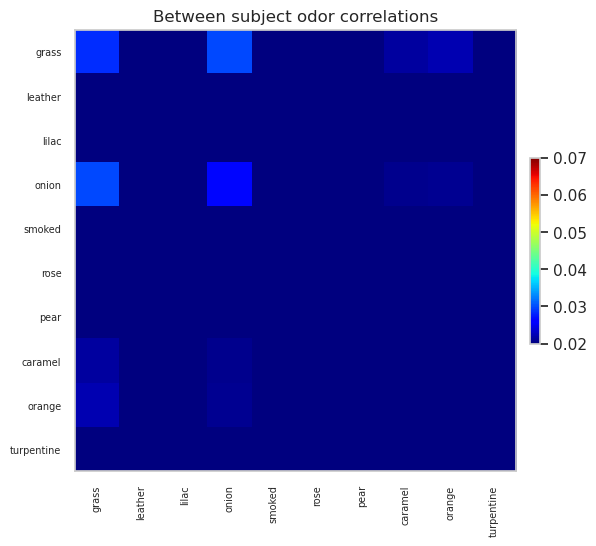

In [185]:
plot_connectivity(avg_corr_od_betw, labels, add_lines=False, plt_title='Between subject odor correlations',
                  min_val=0.02, max_val=0.07, figsize=(6, 6))   

In [11]:
corr_within, corr_betw = sanity_check(sub_maps)
print('Within corr: {:.3f}, Between corr: {:.3f}'.format(np.mean(corr_within), np.mean(corr_betw)))

Within corr: 0.044, Between corr: 0.012


In [ ]:
# Correlate transformed training data.
r_train_hat = np.mean(zscore(sub_maps_hat[0], axis=0) * zscore(sub_maps_hat[1], axis=0), axis=0)

r_3D = np.zeros(od_map.shape)
r_3D[roi_mask_arr] = r_train_hat

plt_r = image.new_img_like(od_map, r_3D)

html_view = plotting.view_img(plt_r, threshold=0.0001, vmax=0.8,
                              cut_coords=[-42, -16, 52],
                              title=None, cmap='bwr')
html_view

In [ ]:
roi_mask

In [ ]:
plt.imshow(sub_corr)

In [ ]:
sub_corr.shape[0] / len(subs)

In [ ]:
r_sub = zscore(sub_maps[0], axis=0) * zscore(sub_maps[0], axis=0)
r_sub.shape

In [ ]:
r_sub = np.mean(zscore(sub_maps[0], axis=0) * zscore(sub_maps[0], axis=0))

In [10]:
subs = list(range(1, 32))
subs.remove(9)
ods = range(1, 11)
runs = range(1, 11)
od_dir = '/home/nikvog/od/maps/'
sl_func = functools.partial(ridge, alpha=1e3)

sub_maps = load_and_mask(
subs=subs, 
ods=ods, 
runs=runs, 
od_dir=od_dir, 
roi_mask=roi_mask, 
verbose=True)

Load: /home/nikvog/od/maps/sub-01_run-01_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-02_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-03_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-04_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-05_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-06_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-07_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-08_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-09_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-10_odorant-01.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-01_odorant-02.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-02_odorant-02.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-03_odorant-02.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-04_odorant-02.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-05_odorant-02.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-06_odorant-02.nii.gz
Load: /home/nikvog/od/maps/sub-01_run-07_odorant-02.nii.

In [ ]:
r_sub

In [3]:
ROI_dir = '/home/nikvog/od/transformed_ROIs/olfactory/'
ROI_name = 'OLFDTI_L_AON_space-MNI152NLin2009cAsym_res-2.nii.gz'  # 'OLFDTI_L_amygdala_space-MNI152NLin2009cAsym_res-2.nii.gz'  # 'OLFDTI_L_temporal_piriform_space-MNI152NLin2009cAsym_res-2.nii.gz'  #
roi_mask = image.load_img(ROI_dir + ROI_name)

roi_mask = image.new_img_like(roi_mask, roi_mask.get_fdata() > 0)


# Compute world coordinates of the seeds
roi_mask_arr, process_mask_affine = masking.load_mask_img(
    roi_mask
)

print('Voxels inside mask:', np.count_nonzero(roi_mask.dataobj))

Voxels inside mask: 383


In [81]:
_ = plot_connectivity_sns(avg_corr_od_within, labels, add_lines=False, plt_title='Within subject odor correlations',
                          min_val=None, max_val=None, figheight=4)

NameError: name 'avg_corr_od_within' is not defined